In [36]:
from __future__ import absolute_import, division, print_function, unicode_literals


 

import re
import skimage
import tensorflow as tf


from tensorflow.keras.models import Sequential, Model, load_model, model_from_json
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, Sequence

from scipy import misc, ndimage  
from glob import glob

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage import data, io, filters, exposure, feature,img_as_float, img_as_ubyte
from skimage.io import imread#,Image
from skimage.transform import resize
from skimage.filters import threshold_otsu, sobel, rank
from skimage.filters.edges import convolve
from skimage.util.dtype import convert
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray

import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
#from matplotlib import pylab as pl
import PIL

from numpy import array

from IPython.display import display
from ipywidgets import interact, interactive, fixed
from IPython.core.display import clear_output
#from os import listdir
#from os.path import join

import warnings
warnings.simplefilter("ignore")

cwd = os.getcwd()
print(cwd)

%matplotlib inline 

C:\Users\Lyokoheros\KCK\RecaptchaSolver\RecaptchaSolver


In [2]:
#przygotowanie danych w pamięci

def przygotujDane(cwd):

    train_dir = cwd + '/dane/train'
    dest_dir = cwd +'/dane/all'
    counter = 0

    for subdir, dirs, files in os.walk(train_dir):
        #print(files)
        for file in files:
            full_path = os.path.join(subdir, file)
            shutil.copy(full_path, dest_dir)
            counter = counter + 1
    #print(counter)

    subdirs, dirs, files = os.walk(dest_dir).__next__()
    m = len(files)
    print(m)

    filenames = []
    labels = np.zeros((m, 1))


    images_dir = dest_dir
    filenames_counter = 0
    labels_counter = -1

    for subdir, dirs, files in os.walk(train_dir):
        #print(files)
        for file in files:
            filenames.append(file)
            labels[filenames_counter, 0] = labels_counter
            filenames_counter = filenames_counter + 1
        labels_counter = labels_counter+1

    #print(len(filenames))
    #print(labels.shape)

    # saving the filename array as .npy file
    np.save('filenames.npy', filenames)


    # One hot vector representation of labels
    y_labels_one_hot = to_categorical(labels)

    # saving the y_labels_one_hot array as a .npy file
    np.save('y_labels_one_hot.npy', y_labels_one_hot)

    filenames_shuffled, y_labels_one_hot_shuffled = shuffle(filenames, y_labels_one_hot)

    # saving the shuffled file.
    # you can load them later using np.load().
    np.save('y_labels_one_hot_shuffled.npy', y_labels_one_hot_shuffled)
    np.save('filenames_shuffled.npy', filenames_shuffled)

    filenames_shuffled_numpy = np.array(filenames_shuffled)

    X_train_filenames, X_val_filenames, y_train, y_val = train_test_split(
        filenames_shuffled_numpy, y_labels_one_hot_shuffled, test_size=0.2, random_state=1)

    #print(X_train_filenames.shape) # (515,)
    #print(y_train.shape)           # (515, 4)
    total_train=X_train_filenames.shape[0]

    #print(X_val_filenames.shape)   # (129,)
    #print(y_val.shape)             # (129, 4)
    total_val=X_val_filenames.shape[0]
    #print("próbek:", total_train, total_val)

    # You can save these files as well. As you will be using them later for training and validation of your model.
    np.save('X_train_filenames.npy', X_train_filenames)
    np.save('y_train.npy', y_train)

    np.save('X_val_filenames.npy', X_val_filenames)
    np.save('y_val.npy', y_val)
    
    return (total_train, total_val, X_train_filenames, y_train, X_val_filenames, y_val, images_dir)

total_train, total_val, X_train_filenames, y_train, X_val_filenames, y_val, images_dir = przygotujDane(os.getcwd())


644
644
644
(644, 1)
(515,)
(515, 4)
(129,)
(129, 4)
próbek: 515 129


In [3]:
#generator do danych
class My_Custom_Generator(tf.keras.utils.Sequence):
    
    
    
    def __init__(self, image_filenames, labels, batch_size, images_dir, IMG_SIZE) :
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.images_dir = images_dir
        self.IMG_SIZE = IMG_SIZE
    
    
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
        return np.array([
            resize(imread(os.path.join(images_dir, str(file_name))), (self.IMG_SIZE, self.IMG_SIZE, 3))
               for file_name in batch_x])/255.0, np.array(batch_y)






In [20]:
#przygotowanie modelu sieci

def przygotujModel(batch_size = 32, IMG_SIZE = 126, 
                   X_train_filenames=X_train_filenames, y_train=y_train, 
                   X_val_filenames=X_val_filenames, y_val=y_val, images_dir=images_dir):
    
    
    my_training_batch_generator = My_Custom_Generator(X_train_filenames, y_train, batch_size, images_dir, IMG_SIZE)
    my_validation_batch_generator = My_Custom_Generator(X_val_filenames, y_val, batch_size, images_dir, IMG_SIZE)
    #label_map = (my_training_batch_generator.class_indices)

    model = Sequential([
        Conv2D(filters = 64, kernel_size = (5,5), activation ='relu',input_shape=(IMG_SIZE,IMG_SIZE,3)),
        BatchNormalization(axis=3),
        Conv2D(filters = 64, kernel_size = (5,5), activation ='relu'),
        MaxPooling2D(pool_size=(2,2)),
        BatchNormalization(axis=3),
        Dropout(0.5),

        Conv2D(filters = 128, kernel_size = (5,5), activation ='relu'),
        BatchNormalization(axis=3),
        Conv2D(filters = 128, kernel_size = (5,5), activation ='relu'),
        MaxPooling2D(pool_size=(2,2)),
        BatchNormalization(axis=3),
        Dropout(0.5),

        Conv2D(filters = 256, kernel_size = (5,5), activation ='relu'),
        BatchNormalization(axis=3),
        Conv2D(filters = 256, kernel_size = (5,5), activation ='relu'),
        MaxPooling2D(pool_size=(2,2)),
        BatchNormalization(axis=3),
        Dropout(0.5),

        Flatten(),

        Dense(256, activation = "relu"), #Fully connected layer
        BatchNormalization(),
        Dropout(0.5),

        Dense(60, activation = "relu"), #Fully connected layer
        BatchNormalization(),
        Dropout(0.5),

        Dense(4, activation = "softmax") #Classification layer or output layer 
    ])

    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

    return (model, my_training_batch_generator, my_validation_batch_generator)

#model = Sequential([
#    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
#    MaxPooling2D(),
#    Conv2D(32, 3, padding='same', activation='relu'),
#    MaxPooling2D(),
#    Conv2D(64, 3, padding='same', activation='relu'),
#    MaxPooling2D(),
#    Flatten(),
#    Dense(32, activation='relu'),
#    Dense(1, activation='sigmoid')
#])

#model.compile(optimizer='adam',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

model, my_training_batch_generator, my_validation_batch_generator = przygotujModel()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 122, 122, 64)      4864      
_________________________________________________________________
batch_normalization_16 (Batc (None, 122, 122, 64)      256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 118, 118, 64)      102464    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 59, 59, 64)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 59, 59, 64)        256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 55, 55, 128)      

In [5]:
#trenowanie

def trenuj(epochs = 10, model = model, batch_size=32,
          my_training_batch_generator=my_training_batch_generator,
          my_validation_batch_generator=my_validation_batch_generator): 
    
    history = model.fit_generator(generator=my_training_batch_generator,
                       steps_per_epoch = int(total_train// batch_size),
                       epochs = epochs,
                       verbose = 1,
                       validation_data = my_validation_batch_generator,
                       validation_steps = int(total_val// batch_size)
                                 )
    return model

#model=trenuj(epochs=1)

In [6]:
#Podsumowanie wyników
def podsumowanie(epochs = 10, model = model):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [60]:
#przygotowanie sieci(jedna funkcja!)
def przygotujSiec():
        
    model=[]
        
    if os.path.exists(os.path.join(os.getcwd(), "model.json")):
        json_file = open('model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        # load weights into new model
        loaded_model.load_weights("model.h5")
        model = loaded_model

    
    else:
        total_train, total_val, X_train_filenames, y_train, X_val_filenames, y_val, images_dir = przygotujDane(os.getcwd())

        model, my_training_batch_generator, my_validation_batch_generator = przygotujModel()
    
        model = trenuj(epochs=20)
        
        model_json = model.to_json()
        with open("model.json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights("model.h5")
    
        
        
    return model

cwd = os.getcwd()
print(os.path.join(cwd, "dane", "all"))


C:\Users\Lyokoheros\KCK\RecaptchaSolver\RecaptchaSolver\dane\all


In [ ]:

def imageInfo(image):
    width = len(image[0])
    height = len(image)
    return (width, height)

def podziel(dane):
    
    
    path = os.path.join(os.getcwd(), "input", dane)
             
    image = img_as_float(io.imread(path))
    #dividing image on horizontal stripes:
    white = np.array([1, 1, 1])
    horizontal = []
    previousLineIsBorder = True
    start = 0
    end = 0
    width, height = imageInfo(image)
    for i in range(0, height - 1):
        allWhite = True
        for j in range(0, width - 1):
            if sum(np.abs(image[i][j] - white)) >= 0.3:
                allWhite = False
        if allWhite == False and previousLineIsBorder == True:
            previousLineIsBorder = False
            start = i
        if allWhite == True and previousLineIsBorder == False:
            previousLineIsBorder = True
            end = i
            horizontal.append(image[start:end, 0:width])
       
    #extracting individual pictures from stripes:
    pictures = []
    for stripe in horizontal:
        previousLineIsBorder = True
        start = 0
        end = 0
        height = len(stripe)
        width = len(stripe[0])
        print(width, height)
        print(stripe.shape)
        for i in range(0, width - 1):
            allWhite = True
            for j in range(0, height - 1):
                if sum(np.abs(stripe[j][i] - white)) >= 0.3:
                    allWhite = False
            if allWhite == False and previousLineIsBorder == True:
                previousLineIsBorder = False
                start = i
            if allWhite == True and previousLineIsBorder == False:
                previousLineIsBorder = True
                end = i
                pictures.append(stripe[0:height, start:end])
                
    return pictures
    
def przygotujObrazy(obrazy, IMG_SIZE = 126):
    #print(np.asarray(obrazy).shape, "pojedyncze:")
    obrazy = np.asarray(obrazy)
    obrazy = obrazy.reshape([-1,IMG_SIZE,IMG_SIZE,3])
    #print(np.asarray(obrazy).shape)
    #for obraz in obrazy:
    #    obraz = obraz.reshape([-1,IMG_SIZE,IMG_SIZE,3])
    #    #obraz = (np.expand_dims(obraz,0))
    #    print(obraz.shape)
    
    return obrazy

#rozdzielone
def displayPictures(pictures): 
    for pic in pictures:
        plt.imshow(pic)
        #print(pic.shape)
        plt.show()
   
    plt.imshow(out)
    plt.show()
    
#nierozdzielone
#def displayImage(path): 
#    image = img_as_float(io.imread(path)
#    plt.imshow(image)
#    plt.show()

def main():
    print("Starting program... ...")

    #parametry
    dane = "test1.jpg"
    szukane = 'auto'
    IMG_SIZE = 126
    
    #lokalizacja
    cwd = os.getcwd()
    print(cwd)

  
    model = przygotujSiec()
    
    pictures = podziel(dane)
    
    #przygotujObrazy(pictures)


    #model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
       
        
    class_names = glob("dane/train/*") # Reads all the folders in which images are present
    class_names = sorted(class_names) # Sorting them
    #name_id_map = dict(zip(class_names, range(len(class_names))))    

    

    predykcje=[]
    for obraz in pictures:
        pred = model.predict_classes(obraz.reshape([1,126,126,3])) 
        predykcje.append(class_names[pred[0]][11:])
        
    
    predykcje[1]='zebra'
    print(predykcje)
    for i in range(len(predykcje)):
        if predykcje[i]==szukane:
            predykcje[i]=1
        else:
            predykcje[i]=0
        
        
        
    #pictures=zaznaczaj(pictures, predykcje) 
    print(predykcje)
    
    
   

                
                
    
 
    print("Finishing program...")

main ()


Starting program... ...
C:\Users\Lyokoheros\KCK\RecaptchaSolver\RecaptchaSolver
644
644
644
(644, 1)
(515,)
(515, 4)
(129,)
(129, 4)
próbek: 515 129
Epoch 1/20
16/16 [==============================] - 226s 14s/step - loss: 0.9211 - accuracy: 0.6744 - val_loss: 2.2682 - val_accuracy: 0.6289
Epoch 2/20
16/16 [==============================] - 210s 13s/step - loss: 0.7599 - accuracy: 0.6931 - val_loss: 4.7822 - val_accuracy: 0.6289
Epoch 3/20
16/16 [==============================] - 199s 12s/step - loss: 0.7848 - accuracy: 0.6951 - val_loss: 5.6944 - val_accuracy: 0.6289
Epoch 4/20
16/16 [==============================] - 203s 13s/step - loss: 0.7073 - accuracy: 0.6919 - val_loss: 4.7291 - val_accuracy: 0.6289
Epoch 5/20
16/16 [==============================] - 179s 11s/step - loss: 0.7243 - accuracy: 0.7048 - val_loss: 2.9179 - val_accuracy: 0.6289
Epoch 6/20
16/16 [==============================] - 193s 12s/step - loss: 0.6436 - accuracy: 0.7241 - val_loss: 3.7738 - val_accuracy: 0.6289

395 126
(126, 395, 3)
395 126
(126, 395, 3)
395 126
(126, 395, 3)
testy:


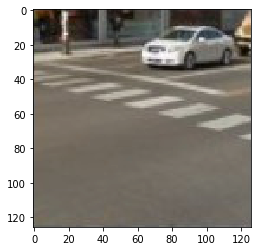

In [35]:
dane = "test1.jpg"    
pictures=podziel(dane)


print("testy:")
plt.imshow(pictures[5])
plt.show()

#plt.imshow(out)
#plt.show()

